In [255]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt 
from pathlib import Path
from PIL import Image
from utils import resize_and_crop

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam

In [256]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
# data preparation
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=None)
images, labels = mnist_train.data, mnist_train.targets

# Only the digits 0, 1, and 2 were used in the target dataset
target_idx = np.where(labels < 3)[0] 
foreground = images[target_idx,:].reshape(-1, 28*28) / 255. 
target_labels = labels[target_idx]

print(foreground.shape, target_labels.shape)

torch.Size([18623, 784]) torch.Size([18623])


In [258]:
# Imagenet data -> grass
IMAGENET_PATH = "./data/imagenet/grass_images/"

grass_imgs = []
for fpath in Path(IMAGENET_PATH).iterdir():
    if fpath.suffix != ".JPEG": 
        print("unknown file extension:", fpath)
        continue

    try:
        im = Image.open(fpath)
        im = im.convert(mode="L") # grayscale
        im = resize_and_crop(im, size=(100,100), crop_type="middle") # resize and crop to 100px x 100px
        grass_imgs.append(np.reshape(im, 10000))
    except Exception as e:
        print(e)
        print("unknown error:", fpath)
    
grass_imgs = np.asarray(grass_imgs, dtype="float32") / 255. # rescale to 0-1
grass_imgs = torch.tensor(grass_imgs)
print(grass_imgs.shape)

torch.Size([1274, 10000])


In [259]:
rand_idxs = np.random.permutation(grass_imgs.shape[0])
split = int(len(rand_idxs)) // 2

target_idxs = rand_idxs[:split]
background_idxs = rand_idxs[split:]

target = torch.zeros_like(foreground)
background = torch.zeros_like(foreground)

In [268]:
scale = 1.5
for i in range(target.shape[0]):
    idx = np.random.choice(target_idxs) # randomly pick an image
    loc = np.random.randint(70, size=(2))
    
    grass_img = np.reshape(grass_imgs[idx,:], (100,100))
    superimposed_patch = np.reshape(grass_img[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28],(1,784)) # randomly pick a region in the grass image
    target[i] = foreground[i] + scale * superimposed_patch
    # target[i] = 0.5 * foreground[i] + superimposed_patch
    
    idx = np.random.choice(background_idxs)
    loc = np.random.randint(70, size=(2))
    grass_img = np.reshape(grass_imgs[idx,:], (100,100))
    background_patch = np.reshape(grass_img[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28],(1,784))
    background[i] = background_patch

# normalize
target /= target.max()
background /= background.max()

In [426]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim, bias=False)
        self.z_mean_layer = nn.Linear(hidden_dim, latent_dim, bias=False)
        self.z_logvar_layer = nn.Linear(hidden_dim, latent_dim, bias=False)

    def reparametrize(self, mean, logvar):
        eps = torch.randn_like(logvar)
        return mean + eps * torch.exp(logvar/2.) # log-var trick
    
    def forward(self, x):
        x = self.input_layer(x)
        z = F.relu(x)
        z_mean, z_logvar = self.z_mean_layer(z), self.z_logvar_layer(z)
        z = self.reparametrize(z_mean, z_logvar)
        return z, z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.latent_layer = nn.Linear(2*latent_dim, hidden_dim, bias=False)
        self.output_layer = nn.Linear(hidden_dim, input_dim, bias=False)

    def forward(self, x):
        x = self.latent_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(2*latent_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

class ContrastiveVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, tc=False, gamma=1, beta=1):
        super().__init__()

        self.z_encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.s_encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)
        self.discriminator = Discriminator(latent_dim)
        
        self.tc = tc
        self.gamma = gamma
        self.beta = beta
    
    def forward(self, tg, bg):
        """
        tg = target; bg = background
        """
        tg_z, tg_z_mean, tg_z_logvar = self.z_encoder(tg)
        tg_s, tg_s_mean, tg_s_logvar = self.s_encoder(tg)
        # bg_s, bg_s_mean, bg_s_logvar = self.s_encoder(bg)
        bg_z, bg_z_mean, bg_z_logvar = self.z_encoder(bg) ## TODO: needs to be z, not s?

        tg_outputs = self.decoder(torch.cat([tg_z, tg_s], dim=1))
        zeros = torch.zeros_like(tg_z)
        # bg_outputs = self.decoder(torch.cat([zeros, bg_s]))
        bg_outputs = self.decoder(torch.cat([bg_z, zeros], dim=1))
        # fg_outputs = self.decoder(torch.cat([tg_z, zeros]))
        fg_outputs = self.decoder(torch.cat([zeros, tg_s], dim=1))

        return {
            "tg_outputs": tg_outputs,
            "bg_outputs": bg_outputs,
            "fg_outputs": fg_outputs,
            "tg_z": tg_z,
            "tg_z_mean": tg_z_mean,
            "tg_z_logvar": tg_z_logvar,
            "tg_s": tg_s,
            "tg_s_mean": tg_s_mean,
            "tg_s_logvar": tg_s_logvar,
            "bg_z": bg_z,
            "bg_z_mean": bg_z_mean,
            "bg_z_logvar": bg_z_logvar,
        }

    def reconstruction_loss(self, inputs, outputs):
        rec_loss = torch.sum(F.mse_loss(inputs, outputs, reduction="none"), axis=1) # sum over pixels
        return rec_loss.mean()
        
    def kl_loss(self, z_mean, z_logvar):
        kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), axis=1)
        return kl_loss.mean()
        
    def tc_loss(self, tg_z, tg_s):
        # assert len(tg_z) % 2 == 0, f"invalid shape tg_z ({tg_z.shape})"
        z1, z2 = torch.chunk(tg_z, 2, dim=0)
        
        # assert len(tg_s) % 2 == 0, f"invalid shape tg_s ({tg_s.shape})"
        s1, s2 = torch.chunk(tg_s, 2, dim=0)

        q = torch.concat([
            torch.concat([s1, z1], axis=1),
            torch.concat([s2, z2], axis=1),
        ], axis=0)
        q_score = self.discriminator(q)
        
        q_bar = torch.concat([
            torch.concat([s1, z2], axis=1),
            torch.concat([z1, s2], axis=1),
        ], axis=0)
        q_bar_score = self.discriminator(q_bar)

        tc_loss = (q_score / (1 - q_score)).log().mean()
        discriminator_loss = (-q_score.log() - (1 - q_bar_score).log()).mean()
        return tc_loss, discriminator_loss
        
    def vae_loss(
        self, 
        tg_inputs, tg_outputs, 
        bg_inputs, bg_outputs, 
        tg_z, tg_z_mean, tg_z_logvar, 
        tg_s, tg_s_mean, tg_s_logvar, 
        bg_z, bg_z_mean, bg_z_logvar,
    ):
        reconst_loss_tg = self.reconstruction_loss(tg_inputs, tg_outputs) 
        reconst_loss_bg = self.reconstruction_loss(bg_inputs, bg_outputs)
        reconst_loss = reconst_loss_tg + reconst_loss_bg

        kl_loss_tg_z = self.kl_loss(tg_z_mean, tg_z_logvar)
        kl_loss_tg_s = self.kl_loss(tg_s_mean, tg_s_logvar)
        kl_loss_bg_z = self.kl_loss(bg_z_mean, bg_z_logvar)
        kl_loss = kl_loss_tg_z + kl_loss_tg_s + kl_loss_bg_z

        tc_loss = self.tc_loss(tg_z, tg_s)

        if self.tc:
            tc_loss, discriminator_loss = self.tc_loss(tg_z, tg_s)
        else:
            tc_loss, discriminator_loss = 0, 0
        
        vae_loss = reconst_loss + self.beta * kl_loss + self.gamma * tc_loss + discriminator_loss
        return reconst_loss, kl_loss, tc_loss, discriminator_loss, vae_loss

In [484]:
model = ContrastiveVAE(input_dim=28*28, hidden_dim=32, latent_dim=2, tc=True)

In [485]:
batch_size = 128
ds = torch.stack([target, background], axis=1)
train_dataloader = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=True) ## drop_last=False

optimizer = Adam(model.parameters(), lr=1e-4)

In [486]:
model.train()

vae_losses = []
rec_losses = []
kl_losses = []
tc_losses = []
d_losses = []
losses = []

overall_loss = 0
for epoch in range(500):    
    epoch_loss = 0
    e_reconst_loss = 0
    e_kl_loss = 0
    e_tc_loss = 0
    e_d_loss = 0
    for batch_idx, x in enumerate(train_dataloader):
        tg, bg = x[:,0,:], x[:,1,:]
        
        optimizer.zero_grad()
        
        out = model(tg, bg)
        reconst_loss, kl_loss, tc_loss, discriminator_loss, vae_loss = model.vae_loss(tg, out["tg_outputs"], bg, out["bg_outputs"], 
                                                                                      out["tg_z"], out["tg_z_mean"], out["tg_z_logvar"], 
                                                                                      out["tg_s"], out["tg_s_mean"], out["tg_s_logvar"],
                                                                                      out["bg_z"], out["bg_z_mean"], out["bg_z_logvar"])
        
        overall_loss += vae_loss.item()
        epoch_loss += vae_loss.item()
        vae_losses.append(vae_loss.item())
        
        e_reconst_loss += reconst_loss.item()
        rec_losses.append(reconst_loss.item())
        
        e_kl_loss += kl_loss.item()
        kl_losses.append(kl_loss.item())
        
        e_tc_loss += tc_loss.item()
        tc_losses.append(tc_loss.item())
        
        e_d_loss += discriminator_loss.item()
        d_losses.append(discriminator_loss.item())
        
        vae_loss.backward()
        optimizer.step()
    
    epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(epoch_loss)
    overall_losses.append(overall_loss / ((epoch+1)*len(train_dataloader)))
    # print("\tEpoch", epoch, "\tEpoch Loss:", round(epoch_loss, 4), "\tRec. Loss:", e_reconst_loss, "\tKL Loss:", e_kl_loss,
    #       "\tTC Loss:", round(e_tc_loss, 4), "\tD Loss:", round(e_d_loss, 4),
    #       "\tAverage Loss: ", round(overall_loss / ((epoch+1)*len(train_dataloader)), 4))

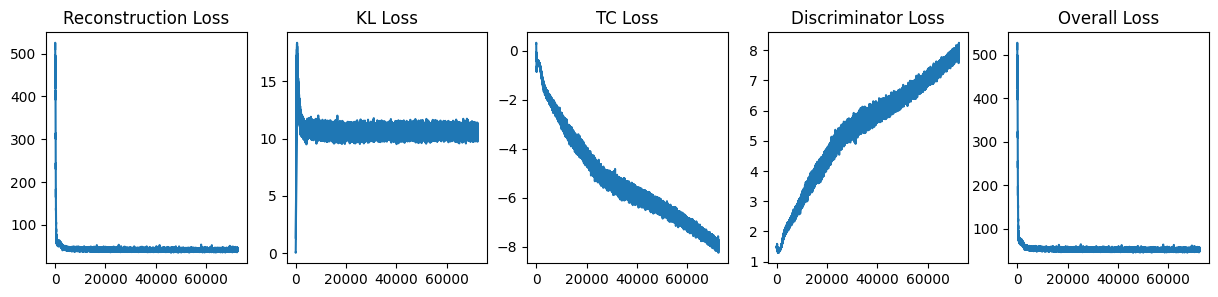

In [487]:
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(15,3))
ax1.plot(rec_losses); ax1.set_title("Reconstruction Loss")
ax2.plot(kl_losses); ax2.set_title("KL Loss")
ax3.plot(tc_losses); ax3.set_title("TC Loss")
ax4.plot(d_losses); ax4.set_title("Discriminator Loss")
ax5.plot(vae_losses); ax5.set_title("Overall Loss");

In [488]:
# inference

new_batch = next(iter(train_dataloader))
tg, bg = new_batch[:,0,:], new_batch[:,1,:]
out = model(tg, bg)

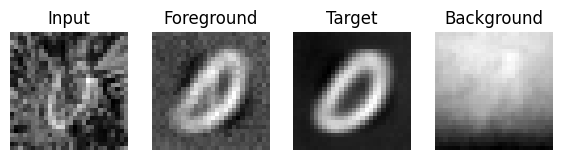

In [489]:
rand_idx = np.random.choice(len(new_batch))

_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(7,7))
ax1.axis("off"); ax2.axis("off"); ax3.axis("off"); ax4.axis("off")

tg_input = new_batch[rand_idx,0,:].reshape(28,28)
bg_input = new_batch[rand_idx,1,:].reshape(28,28)
tg_output = out["tg_outputs"][rand_idx].reshape(28,28).detach().numpy()
fg_output = out["fg_outputs"][rand_idx].reshape(28,28).detach().numpy()
bg_output = out["bg_outputs"][rand_idx].reshape(28,28).detach().numpy()

ax1.imshow(tg_input, cmap="gray"); ax1.set_title("Input")
ax2.imshow(fg_output, cmap="gray"); ax2.set_title("Foreground")
ax3.imshow(tg_output, cmap="gray"); ax3.set_title("Target")
ax4.imshow(bg_output, cmap="gray"); ax4.set_title("Background");

In [ ]:
# reproduce experiment result

In [ ]:
def plot_sweeps_mnist(decoder):
    # TODO: replace with ImageGrid (mpl_toolkits) and torchvision
    n = 30
    fig = np.zeros((28*n, 28*n))
    

In [78]:
from models import VAE, train_vae, ContrastiveVAE, train_cvae

In [42]:
# create dataloader
batch_size = 128
train_dataloader = DataLoader(dataset=target, batch_size=batch_size, shuffle=True, drop_last=True)

vae = VAE(input_dim=28*28, hidden_dim=32, latent_dim=2)
optimizer = Adam(vae.parameters())
train_vae(vae, optimizer, train_dataloader, epochs=50);

In [95]:
batch_size = 128
ds = torch.stack([target, background], axis=1)
train_dataloader = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=True)

optimizer = Adam(vae.parameters(), lr=1e-4)
train_cvae(cvae, optimizer, train_dataloader, epochs=50, verbose=1)

	Epoch 0 	Average Loss:  42034.7445
	Epoch 1 	Average Loss:  42037.1893
	Epoch 2 	Average Loss:  42043.9008
	Epoch 3 	Average Loss:  42028.4993
	Epoch 4 	Average Loss:  42024.278
	Epoch 5 	Average Loss:  42028.3827
	Epoch 6 	Average Loss:  42035.3366
	Epoch 7 	Average Loss:  42050.8577
	Epoch 8 	Average Loss:  42039.5113
	Epoch 9 	Average Loss:  42043.4332
	Epoch 10 	Average Loss:  42023.984
	Epoch 11 	Average Loss:  42046.8019
	Epoch 12 	Average Loss:  42039.1956
	Epoch 13 	Average Loss:  42024.9348
	Epoch 14 	Average Loss:  42039.6664
	Epoch 15 	Average Loss:  42042.7775
	Epoch 16 	Average Loss:  42039.2084
	Epoch 17 	Average Loss:  42041.7023
	Epoch 18 	Average Loss:  42038.1307
	Epoch 19 	Average Loss:  42047.8947
	Epoch 20 	Average Loss:  42031.138
	Epoch 21 	Average Loss:  42037.5095
	Epoch 22 	Average Loss:  42046.7035
	Epoch 23 	Average Loss:  42025.7641
	Epoch 24 	Average Loss:  42044.7824
	Epoch 25 	Average Loss:  42033.2863
	Epoch 26 	Average Loss:  42040.6244
	Epoch 27 	Ave

[42034.74445043103,
 42037.18927801724,
 42043.90075431034,
 42028.49927262931,
 42024.27804418103,
 42028.38265086207,
 42035.33661099138,
 42050.85767780172,
 42039.511314655174,
 42043.43316271552,
 42023.983970905174,
 42046.80185883621,
 42039.19558189655,
 42024.93477909483,
 42039.66640625,
 42042.777478448275,
 42039.20837823276,
 42041.70228987069,
 42038.13068426724,
 42047.894719827586,
 42031.13801185345,
 42037.50950969828,
 42046.703475215516,
 42025.764143318964,
 42044.78243534483,
 42033.286314655175,
 42040.62435344828,
 42045.972521551725,
 42044.885721982755,
 42033.586072198275,
 42039.41737607759,
 42035.365813577584,
 42040.76390086207,
 42033.36018318965,
 42039.56088362069,
 42025.28345905172,
 42038.56885775862,
 42034.97020474138,
 42051.44057112069,
 42032.50471443965,
 42043.68265086207,
 42041.05546875,
 42027.67160560345,
 42041.87645474138,
 42037.90436422414,
 42047.8114762931,
 42046.73453663793,
 42034.34905711207,
 42038.02664331897,
 42042.485991379

In [61]:
from sklearn.metrics import silhouette_score # quality of clustering

def plot_latent_space(model, x, y, name):
    if name == "VAE":
        z_mean, _ = model.encode(x)
    elif name == "cVAE":
        _, z_mean, _ = model.z_encode(x)
    else:
        raise ValueError("unknown name:", name)
    
    if torch.is_tensor(z_mean):
        z_mean = z_mean.detach().numpy()
    if torch.is_tensor(y):
        y = y.detach().numpy()
        
    ss = silhouette_score(z_mean, y)
    
    _, ax = plt.subplots()
    ax.scatter(z_mean[:,0], z_mean[:, 1], c=target_labels, cmap="Accent")
    ax.set_title(f"{name}, Silhouette score: {round(ss, 3)}")

    return ss

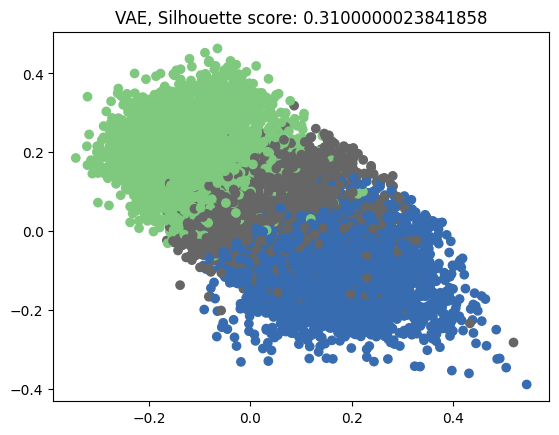

In [59]:
plot_latent_space(vae, target, target_labels, name="VAE");

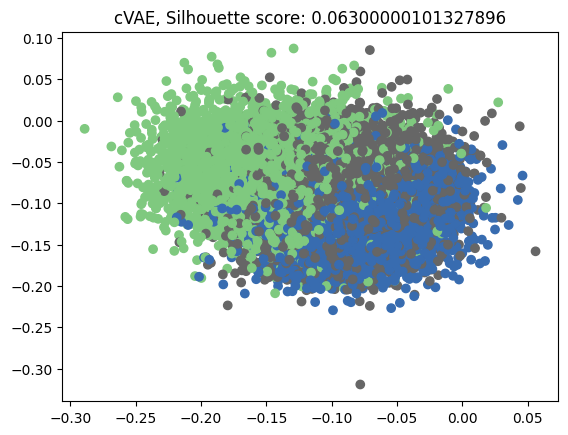

In [93]:
plot_latent_space(cvae, target, target_labels, name="cVAE");